# Concrete Crack Detection using ResNet101 Transfer Learning

This notebook implements a binary classification model to detect concrete cracks using transfer learning with ResNet101 pre-trained on ImageNet. The model classifies images as either containing cracks (Positive) or being crack-free (Negative).

Dataset Citation:
Özgenel, Çağlar Fırat (2019), “Concrete Crack Images for Classification”, Mendeley Data, V2, doi: [10.17632/5y9wdsg2zt.2](https://data.mendeley.com/datasets/5y9wdsg2zt/2)

NB Author: [SimonGonMon](https://github.com/SimonGonMon)


## Import Required Libraries

Import necessary libraries for data processing, model building, and visualization.


In [3]:
import tensorflow as tf
from tensorflow import keras

# Add type ignore to avoid Pylance errors (personal thing)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # type: ignore
from tensorflow.keras.applications import ResNet101  # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # type: ignore
from tensorflow.keras.models import Model  # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # type: ignore

import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset Configuration

Set up data paths and parameters for the concrete crack detection dataset.


In [4]:
# Data configuration
DATA_DIR = "data/Concrete Cracks"  # We expect Positive and Negative subfolders
IMAGE_SIZE = (227, 227)
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

# Model configuration
NUM_CLASSES = 2
LEARNING_RATE = 0.0001
EPOCHS = 25

# Check if data directory exists
if os.path.exists(DATA_DIR):
    print(f"Data directory found: {DATA_DIR}")

    # Count images in each class
    positive_count = len(os.listdir(os.path.join(DATA_DIR, "Positive")))
    negative_count = len(os.listdir(os.path.join(DATA_DIR, "Negative")))

    print(f"Positive samples (with cracks): {positive_count}")
    print(f"Negative samples (without cracks): {negative_count}")
    print(f"Total samples: {positive_count + negative_count}")
else:
    print(f"Error: Data directory not found: {DATA_DIR}")

Data directory found: data/Concrete Cracks
Positive samples (with cracks): 20000
Negative samples (without cracks): 20000
Total samples: 40000


## Data Preprocessing with ImageDataGenerator

Configure ImageDataGenerator for loading and preprocessing images without transformations for data augmentation. The images are already pretty clean with many different angles and sizes, so we will not apply any transformations.


In [5]:
# Rescale pixel values to [0,1] range as required by ResNet101
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=VALIDATION_SPLIT)

# Training data generator
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42,
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Training samples: 32000
Validation samples: 8000
Class indices: {'Negative': 0, 'Positive': 1}


## Data Preview

Display sample images from both classes to visualize the dataset.


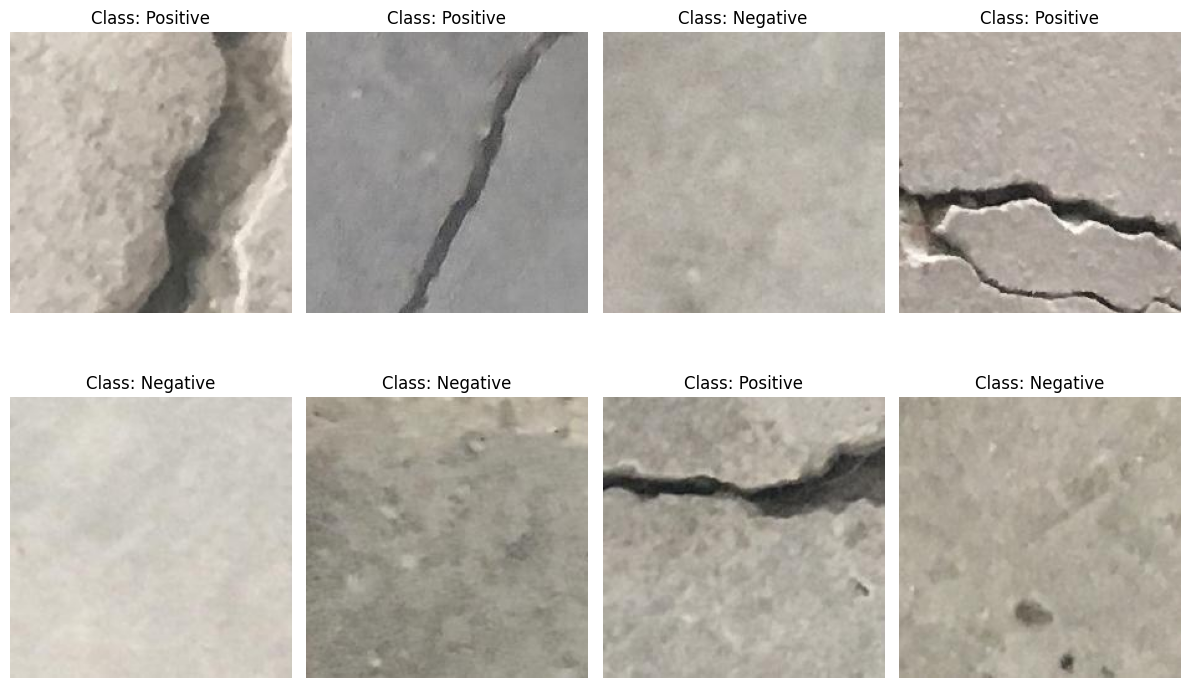

In [6]:
# Preview sample images from the dataset
def show_sample_images():
    # Get a batch of training data
    sample_batch = next(train_generator)
    images, labels = sample_batch

    # Class names
    class_names = list(train_generator.class_indices.keys())

    # Display 8 sample images
    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Reset generator
    train_generator.reset()


show_sample_images()

## Model Architecture - ResNet101

Build the transfer learning model using pre-trained ResNet101 as the base with custom classification layers.


In [7]:
# Load pre-trained ResNet101 without top classification layers using weights from ImageNet
base_model = ResNet101(
    weights="imagenet", include_top=False, input_shape=(*IMAGE_SIZE, 3)
)

# Freeze base model layers for transfer learning
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation="softmax")(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Display model summary
print("Model Architecture:")
print(f"Total parameters: {model.count_params():,}")
print(
    f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}"
)
print(
    f"Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}"
)

model.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Model Architecture:
Total parameters: 43,215,874
Trainable parameters: 557,698
Non-trainable parameters: 42,658,176


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 227, 227,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 233, 233,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 114, 114,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 114, 114,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 114, 114,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 116, 116,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 57, 57,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 57, 57,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 57, 57,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 57, 57,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 57, 57,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 57, 57,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 57, 57,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 57, 57,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 57, 57,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 57, 57,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 57, 57,    │      1,024 │ conv2_block1_3_c

 Total params: 43,215,874 (164.86 MB)

 Trainable params: 557,698 (2.13 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

## Training Configuration

Set up callbacks for training optimization and monitoring.


In [8]:
# Configure training callbacks
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1
    ),
]

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Training will run for maximum {EPOCHS} epochs")

Steps per epoch: 500
Validation steps: 125
Training will run for maximum 25 epochs


## Model Training

Train the transfer learning model on the concrete crack detection dataset.


In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 239s 426ms/step - accuracy: 0.6698 - loss: 0.6236 - val_accuracy: 0.9355 - val_loss: 0.2114 - learning_rate: 1.0000e-04
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 246s 418ms/step - accuracy: 0.9332 - loss: 0.2228 - val_accuracy: 0.9590 - val_loss: 0.1374 - learning_rate: 1.0000e-04
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 262s 417ms/step - accuracy: 0.9416 - loss: 0.1745 - val_accuracy: 0.9651 - val_loss: 0.1101 - learning_rate: 1.0000e-04
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 209s 417ms/step - accuracy: 0.9506 - loss: 0.1489 - val_accuracy: 0.9654 - val_loss: 0.1033 - learning_rate: 1.0000e-04
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 263s 420ms/step - accuracy: 0.9554 - loss: 0.1389 - val_accuracy: 0.9694 - val_loss: 0.1023 - learning_rate: 1.0000e-04
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 261s 418ms/step - accuracy: 0.9547 - loss: 0.1400 - val_accuracy: 0.9696 - val_loss: 0.0901 - learning_rate: 1.0000e-04
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 

## Training Results Visualization

Plot training and validation metrics to analyze model performance.


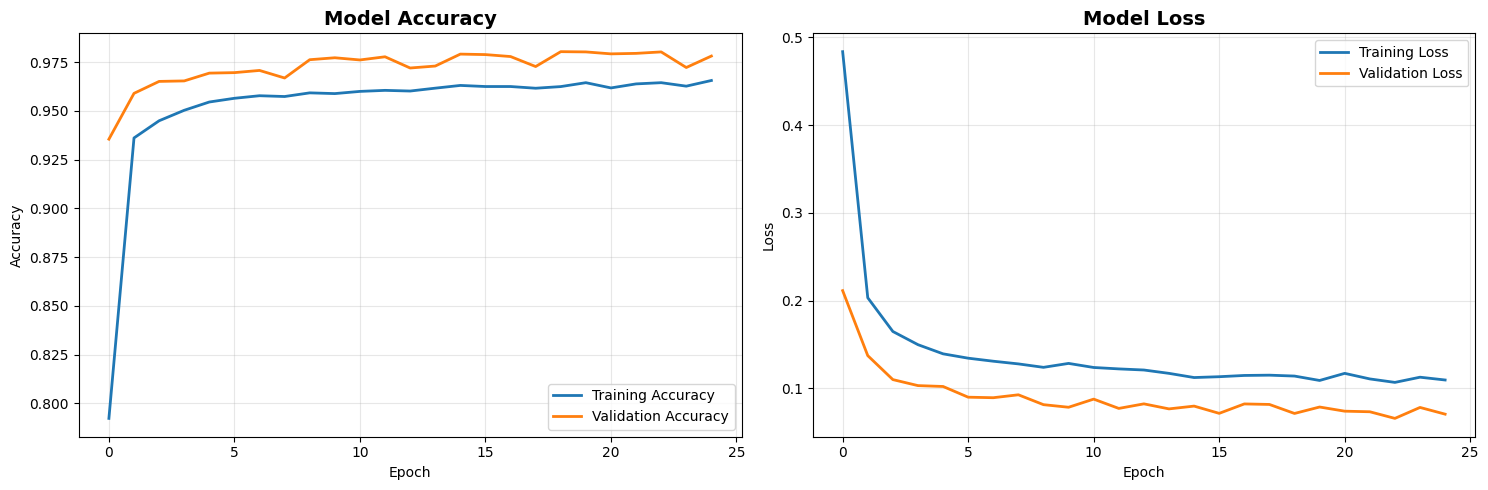

In [10]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history["accuracy"], label="Training Accuracy", linewidth=2)
    ax1.plot(history.history["val_accuracy"], label="Validation Accuracy", linewidth=2)
    ax1.set_title("Model Accuracy", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history["loss"], label="Training Loss", linewidth=2)
    ax2.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
    ax2.set_title("Model Loss", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
    plt.show()


plot_training_history(history)

## Model Evaluation

Evaluate the trained model performance on validation data with detailed metrics.


Evaluating model on validation data...
Validation Loss: 0.0660
Validation Accuracy: 0.9803

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.99      0.98      4000
    Positive       0.99      0.97      0.98      4000

    accuracy                           0.98      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000



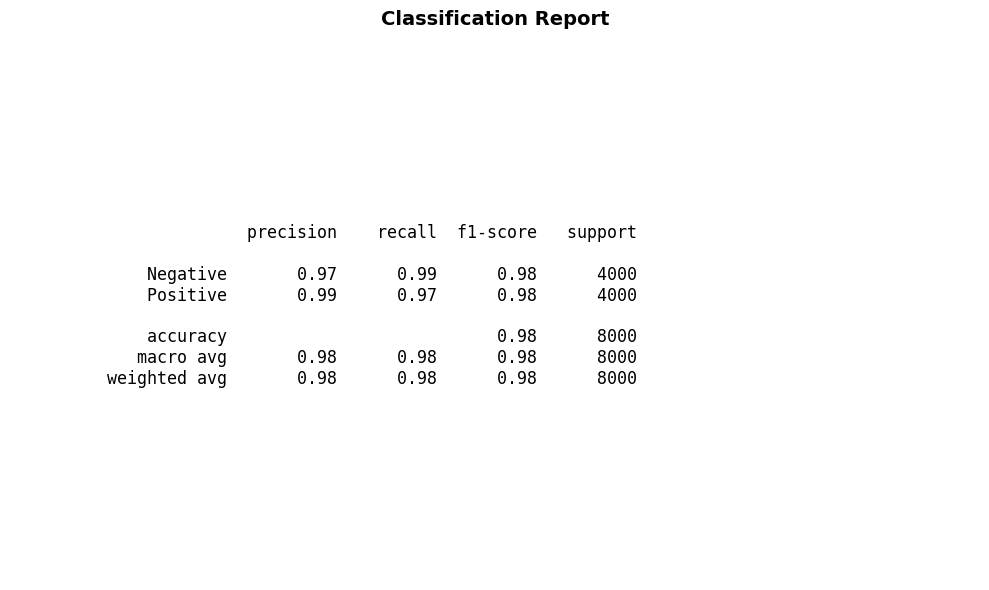

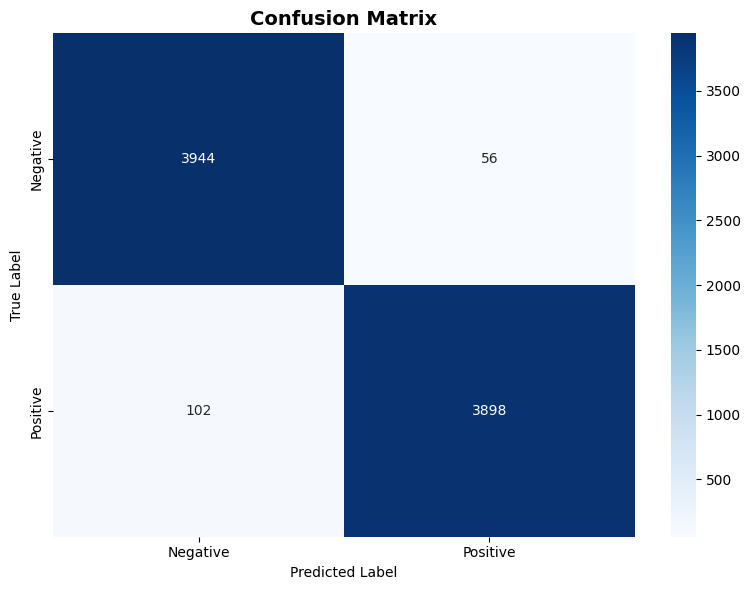

In [11]:
# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions for detailed evaluation
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print("=" * 50)
classification_report_text = classification_report(
    true_classes, predicted_classes, target_names=class_labels
)
print(classification_report_text)

# Save classification report as image
fig, ax = plt.subplots(figsize=(10, 6))
ax.text(
    0.1,
    0.5,
    classification_report_text,
    fontfamily="monospace",
    fontsize=12,
    verticalalignment="center",
    transform=ax.transAxes,
)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")
ax.set_title("Classification Report", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.savefig("classification_report.png", dpi=300, bbox_inches="tight")
plt.show()

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

## Training Statistics Export

Export comprehensive training statistics and model performance metrics.


In [12]:
# Compile training statistics
import json
from datetime import datetime

training_stats = {
    "model_info": {
        "architecture": "ResNet101 Transfer Learning",
        "base_model": "ResNet101 (ImageNet)",
        "input_shape": IMAGE_SIZE + (3,),
        "num_classes": NUM_CLASSES,
        "total_parameters": int(model.count_params()),
        "trainable_parameters": int(
            sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
        ),
    },
    "training_config": {
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "epochs_trained": len(history.history["loss"]),
        "max_epochs": EPOCHS,
        "validation_split": VALIDATION_SPLIT,
    },
    "dataset_info": {
        "training_samples": train_generator.samples,
        "validation_samples": validation_generator.samples,
        "class_distribution": {"negative": negative_count, "positive": positive_count},
    },
    "final_metrics": {
        "training_accuracy": float(history.history["accuracy"][-1]),
        "training_loss": float(history.history["loss"][-1]),
        "validation_accuracy": float(history.history["val_accuracy"][-1]),
        "validation_loss": float(history.history["val_loss"][-1]),
        "best_validation_accuracy": float(max(history.history["val_accuracy"])),
        "best_validation_loss": float(min(history.history["val_loss"])),
    },
    "training_history": {
        "accuracy": [float(x) for x in history.history["accuracy"]],
        "val_accuracy": [float(x) for x in history.history["val_accuracy"]],
        "loss": [float(x) for x in history.history["loss"]],
        "val_loss": [float(x) for x in history.history["val_loss"]],
    },
    "timestamp": datetime.now().isoformat(),
}

# Save training statistics
with open("training_statistics.json", "w") as f:
    json.dump(training_stats, f, indent=2)

print("Training Statistics Summary:")
print("=" * 50)
print(f"Model: {training_stats['model_info']['architecture']}")
print(f"Total Parameters: {training_stats['model_info']['total_parameters']:,}")
print(f"Trainable Parameters: {training_stats['model_info']['trainable_parameters']:,}")
print(f"Epochs Trained: {training_stats['training_config']['epochs_trained']}")
print(
    f"Final Training Accuracy: {training_stats['final_metrics']['training_accuracy']:.4f}"
)
print(
    f"Final Validation Accuracy: {training_stats['final_metrics']['validation_accuracy']:.4f}"
)
print(
    f"Best Validation Accuracy: {training_stats['final_metrics']['best_validation_accuracy']:.4f}"
)
print(f"Training Samples: {training_stats['dataset_info']['training_samples']}")
print(f"Validation Samples: {training_stats['dataset_info']['validation_samples']}")
print(f"\nTraining statistics exported to: training_statistics.json")

Training Statistics Summary:
Model: ResNet101 Transfer Learning
Total Parameters: 43,215,874
Trainable Parameters: 557,698
Epochs Trained: 25
Final Training Accuracy: 0.9656
Final Validation Accuracy: 0.9781
Best Validation Accuracy: 0.9804
Training Samples: 32000
Validation Samples: 8000

Training statistics exported to: training_statistics.json
